In [18]:
# https://plotly.com/~jackp/17421/plotly-candlestick-chart-in-python/#/

import pandas_datareader.data as web
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
from mpl_finance import candlestick_ohlc
import gc

In [2]:
df = web.DataReader("ZLAB", 'yahoo', datetime(2016,1,1), datetime.now()) # This is easier to use

In [3]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-30,53.090000,50.748001,51.529999,52.970001,228000,52.970001
2020-03-31,53.299999,50.174999,53.250000,51.480000,257800,51.480000
2020-04-01,51.910000,47.750000,50.070000,48.820000,316200,48.820000
2020-04-02,51.980000,49.290001,49.290001,51.490002,492400,51.490002
2020-04-03,55.000000,50.000000,51.480000,51.549999,218000,51.549999


In [4]:
class Stock:
    
    def __init__(self, symbol, date_from, date_to):
        self.symbol = symbol
        self.dtf = date_from
        self.dtt = date_to
        
    def get_quote(self):
        df = web.DataReader(self.symbol, 'yahoo', self.dtf, self.dtt) # This is easier to use
        df = df.reset_index(drop = False)
        return df
    
    def get_Min_and_Max(self):
        """ 
        Return a list of Max/Min/Last Pricing information in a list
        """ 
        try:
            df = self.get_quote()
            #df = df.reset_index()
            closeMax = df.iloc[df['Close'].idxmax()] 
            closeMin = df.iloc[df['Close'].idxmin()] 
            closeCurrent = df.iloc[-1,:]
            result = [self.symbol,
                     closeMax['Date'].date(), # Date of highest closing price 
                     closeMax['Close'],       # Max closing price 
                     closeMin['Date'].date(), # Date of lowest closing price
                     closeMin['Close'],       # Min closing Price
                     closeCurrent['Date'].date(), # Last Close price
                     closeCurrent['Close'],    # Last Close Price
                     round((closeMin['Close'] - closeMax['Close'])/closeMax['Close'], 4), # Precent change from high to low
                     round((closeCurrent['Close'] - closeMax['Close'])/closeMax['Close'], 4) # Precent change from high to current
                    ]

            # Remove varible
            del df
            del closeMax
            del closeMin
            del closeCurrent
            gc.collect()

            return result

        except: 
            print('Could not get ' + str(self.symbol) + ' from Yahoo Finance')
    

In [5]:
# https://quant.stackexchange.com/questions/11264/calculating-bollinger-band-correctly
def add_Bollinger_Band(df, window_size = 20, num_sd = 2):
    """ 
    returns average, upper band, and lower band
    """
    df['rolling_mean'] = df['Close'].rolling(window=window_size).mean()
    df['rolling_std']  = df['Close'].rolling(window=window_size).std()
    df['upper_band'] =  round(df['rolling_mean'] + ( df['rolling_std']*num_sd), 4)
    df['lower_band'] =  round(df['rolling_mean'] - ( df['rolling_std']*num_sd),4)
    df = df.drop(columns=['rolling_std'])
    return df

In [6]:
df = Stock("FB",  date_from=datetime(2020,1,1), date_to=datetime.now()).get_quote()
df = add_Bollinger_Band(df)

df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,rolling_mean,upper_band,lower_band
60,2020-03-30,166.750000,158.059998,159.179993,165.949997,22515200,165.949997,164.160500,192.8788,135.4422
61,2020-03-31,170.929993,164.199997,165.479996,166.800003,23676300,166.800003,163.206000,190.0940,136.3180
62,2020-04-01,164.149994,158.039993,161.619995,159.600006,19507600,159.600006,161.598000,184.9040,138.2920
63,2020-04-02,161.350006,155.919998,159.100006,158.190002,20886300,158.190002,160.249001,180.7667,139.7313
64,2020-04-03,157.910004,150.830002,157.149994,154.179993,25972900,154.179993,158.903500,177.0602,140.7468


In [7]:
df.Date = df.Date.dt.normalize()
df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,rolling_mean,upper_band,lower_band
60,2020-03-30,166.750000,158.059998,159.179993,165.949997,22515200,165.949997,164.160500,192.8788,135.4422
61,2020-03-31,170.929993,164.199997,165.479996,166.800003,23676300,166.800003,163.206000,190.0940,136.3180
62,2020-04-01,164.149994,158.039993,161.619995,159.600006,19507600,159.600006,161.598000,184.9040,138.2920
63,2020-04-02,161.350006,155.919998,159.100006,158.190002,20886300,158.190002,160.249001,180.7667,139.7313
64,2020-04-03,157.910004,150.830002,157.149994,154.179993,25972900,154.179993,158.903500,177.0602,140.7468


In [8]:
Stock("FB",  date_from=datetime(2020,1,1), date_to=datetime.now()).get_Min_and_Max()

['FB',
 datetime.date(2020, 1, 29),
 223.22999572753906,
 datetime.date(2020, 3, 16),
 146.00999450683594,
 datetime.date(2020, 4, 3),
 154.17999267578125,
 -0.3459,
 -0.3093]

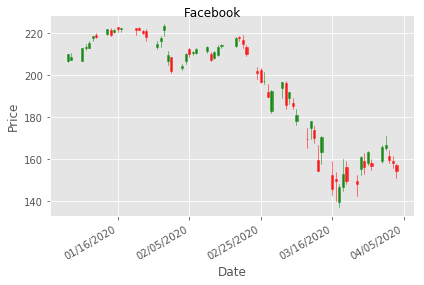

In [23]:
plt.style.use('ggplot')

# Extracting Data for plotting

ohlc = df.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

# Creating Subplots
fig, ax = plt.subplots()

candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Facebook')

# Formatting Date
date_format = mpl_dates.DateFormatter('%m/%d/%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()


plt.show() 